<a href="https://colab.research.google.com/github/Krishanu2206/GANs/blob/main/GANS_Intro_Simple_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Creating first simple GAN

Generator and Discriminator classes


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [2]:

class Discriminator(nn.Module):
  def __init__(self, img_dim):
    super().__init__()
    self.disc = nn.Sequential(
      nn.Linear(img_dim, 128),
      nn.LeakyReLU(0.1), ##in GANs leaky relu is often a better choice than RELU.
      nn.Linear(128, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim): ##z_dim => latent noise
      super().__init__()
      self.gen = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256, img_dim), ##28x28x2 --> 784
        nn.Tanh(),
      )

    def forward(self, x):
      return self.gen(x)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64 # or you can use 128, 256
img_dim = 28*28*1 #784
batch_size = 32
num_epochs = 5

disc = Discriminator(img_dim).to(device)
gen = Generator(z_dim, img_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))] ##first one for mean and second one for std...as fashion MNIST only 1 colour channel is there so only one 0.5 if 3 color channels, 3 0.5 will be present.
)

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer_disc = optim.Adam(disc.parameters(), lr=lr)
optimizer_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step = 0

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 900675.32it/s] 


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 135117.97it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1088088.98it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4968839.01it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



Epoch [0/5] \ Loss D: 0.6911, Loss G: 0.6396


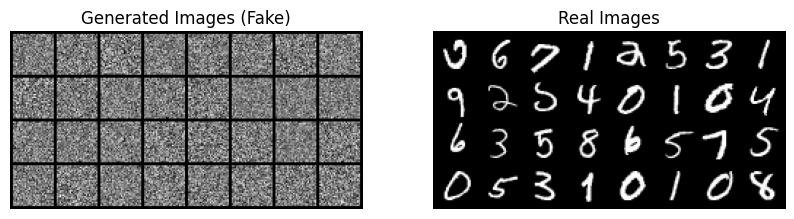

Epoch [1/5] \ Loss D: 0.3392, Loss G: 1.8254


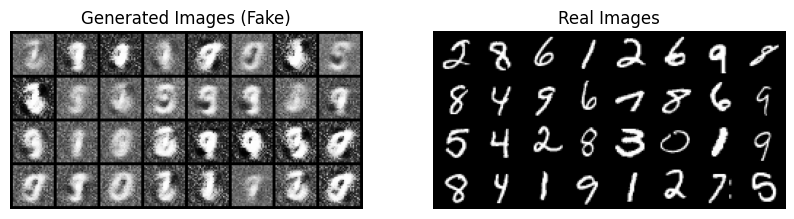

Epoch [2/5] \ Loss D: 0.1255, Loss G: 2.9971


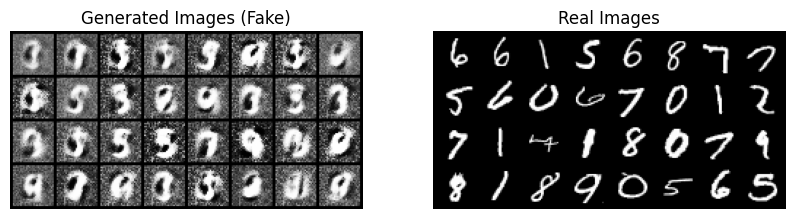

Epoch [3/5] \ Loss D: 0.0492, Loss G: 3.9585


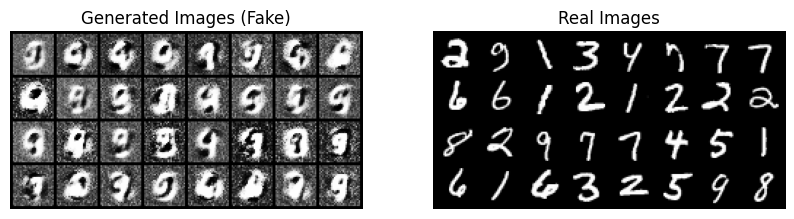

Epoch [4/5] \ Loss D: 0.0356, Loss G: 4.2286


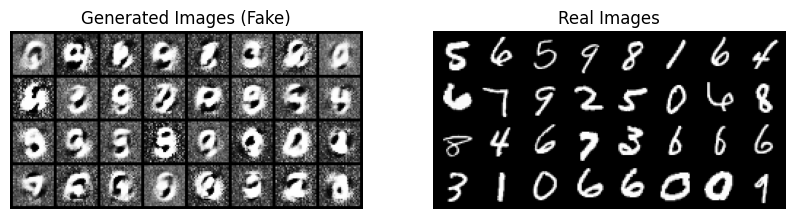

In [5]:
for epoch in range(num_epochs):
  for batch_idx, (real, _) in enumerate(loader):
    real = real.view(-1, 784).to(device)
    batch_size = real.shape[0]

    ##Train Discriminator : max log(D(real)) + log(1-log(G(D(z))))
    noise = torch.randn((batch_size, z_dim)).to(device)
    fake = gen(noise)
    disc_real = disc(real).view(-1)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(fake).view(-1)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    lossD = (lossD_real + lossD_fake) / 2
    disc.zero_grad()
    lossD.backward(retain_graph = True)
    optimizer_disc.step()

    ##train generator : min log(1-D(G(z))) <--> max log(D(G(z)))
    output = disc(fake).view(-1)
    lossG = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    optimizer_gen.step()

    if batch_idx == 0:
        print(
            f"Epoch [{epoch}/{num_epochs}] \ "
            f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
        )

        with torch.no_grad():
            # Generating fake images and reshaping real images
            fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
            data = real.reshape(-1, 1, 28, 28)

            # Creating grid for fake and real images
            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            img_grid_real = torchvision.utils.make_grid(data, normalize=True)

            # Plotting the fake images
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy())
            ax[0].set_title('Generated Images (Fake)')
            ax[0].axis('off')

            # Plotting the real images
            ax[1].imshow(img_grid_real.permute(1, 2, 0).cpu().numpy())
            ax[1].set_title('Real Images')
            ax[1].axis('off')

            # Display the plot
            plt.show()
